In [1]:

%pprint
import sys
if (osp.join('..', 'py') not in sys.path): sys.path.insert(1, osp.join('..', 'py'))

Pretty printing has been turned OFF


In [2]:

import os.path as osp
shared_folder = osp.abspath(osp.join('..', 'share')); assert osp.exists(shared_folder)
import sys
if shared_folder not in sys.path: sys.path.insert(1, shared_folder)
from notebook_utils import NotebookUtilities
nu = NotebookUtilities(
    data_folder_path=osp.abspath(osp.join('..', 'data')),
    saves_folder_path=osp.abspath(osp.join('..', 'saves'))
)

# Import needed libraries
from pandas import DataFrame
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os, re
import pandas as pd


# Analyze Util Function Usage Frequency

In [3]:

nu.delete_ipynb_checkpoint_folders()


## Create a within-function function-call node-and-edge network visualization

In [4]:

# Get the list of files with our classes in them
classes_list = [
    'ChartUtilities', 'CrfUtilities', 'CypherUtilities', 'ElementAnalysis', 'HeaderAnalysis', 'HeaderCategories', 'HtmlVectorizer', 'IsCorporateScopeSgdClassifier',
    'IsEducationalRequirementSgdClassifier', 'IsHeaderSgdClassifier', 'IsInterviewProcedureSgdClassifier', 'IsJobDurationSgdClassifier', 'IsJobTitleSgdClassifier',
    'IsLegalNotificationSgdClassifier', 'IsOfficeLocationSgdClassifier', 'IsOtherSgdClassifier', 'IsPostingDateSgdClassifier', 'IsPreferredQualificationSgdClassifier',
    'IsQualificationSgdClassifier', 'IsRequiredQualificationSgdClassifier', 'IsSupplementalPaySgdClassifier', 'IsTaskScopeSgdClassifier', 'LdaUtilities', 'LrUtilities',
    'NotebookUtilities', 'PosSymbolSgdClassifier', 'SectionCRFClassifierUtilities', 'SectionLRClassifierUtilities', 'SectionSGDClassifierUtilities', 'SectionUtilities', 'SqlUtilities',
    'Storage', 'WebScrapingUtilities'
]
classes_regex = re.compile('^class +(' + '|'.join(classes_list) + ')', re.MULTILINE)
file_paths_list = []
py_folder = osp.abspath(osp.join('..', 'py'))
black_list = ['$RECYCLE.BIN', '$Recycle.Bin', '.git', 'jh_env', '.ipynb_checkpoints']
suffixes_list = ['.py']
class_names_dict = {}
for sub_directory, directories_list, files_list in os.walk(py_folder):
    if all(map(lambda x: x not in sub_directory, black_list)):
        for file_name in files_list:
            if any(map(lambda x: file_name.lower().endswith(x), suffixes_list)):
                file_path = os.path.join(sub_directory, file_name)
                with open(file_path, 'r', encoding=nu.encoding_type) as f:
                    file_text = f.read()
                    if classes_regex.search(file_text):
                        file_paths_list.append(file_path)
                        infile_classes_list = classes_regex.split(file_text)
                        for i, j in zip(range(1, len(infile_classes_list), 2), range(2, len(infile_classes_list), 2)):
                            class_name = osp.basename(file_path) + ',' + infile_classes_list[i]
                            class_names_dict[class_name] = infile_classes_list[2]

In [17]:

# Get a list of all the functions in each module
defs_regex = re.compile(r'^    def ([a-z]+[a-z_]+)\([^\)]+\)[ >a-z0-9-]*:\s+(?:"""[^"]+""")?', re.MULTILINE)
functions_dict = {}
for class_name, defs_str in class_names_dict.items():
    functions_list = []
    defs_list = defs_regex.split(defs_str)
    for fn_name in [defs_list[i] for i in range(1, len(defs_list), 2)]: functions_list.append(fn_name)
    functions_dict[class_name] = functions_list

In [5]:

# Get a list of all the class instantiations
instantiations_dict = {}
suffixes_list = ['.py', '.ipynb']
for class_name in sorted(class_names_dict.keys()):
    instantiations_regex = re.compile(r'\b([a-z_]+)\s*=\s*(' + class_name.replace('.py,', r'\.)?') + r'\b')
    for sub_directory, directories_list, files_list in os.walk(nu.github_folder):
        if all(map(lambda x: x not in sub_directory, black_list)):
            for file_name in files_list:
                if any(map(lambda x: file_name.lower().endswith(x), suffixes_list)):
                    file_path = os.path.join(sub_directory, file_name)
                    with open(file_path, 'r', encoding=nu.encoding_type) as f:
                        file_text = f.read()
                        match_obj = instantiations_regex.search(file_text)
                        if match_obj:
                            variable_name = match_obj.group(1)
                            variable_names_set = instantiations_dict.get(class_name, set())
                            variable_names_set.add(variable_name)
                            instantiations_dict[class_name] = variable_names_set

In [6]:

for class_name, variable_names_set in instantiations_dict.items():

{'crf_utils.py,CrfUtilities': {'crf'}, 'cypher_utils.py,CypherUtilities': {'cu'}, 'ha_utils.py,HeaderAnalysis': {'ha'}, 'hc_utils.py,HeaderCategories': {'hc'}, 'html_analysis.py,ElementAnalysis': {'ea'}, 'html_analysis.py,LdaUtilities': {'lda'}, 'is_corporate_scope_sgd_classifier.py,IsCorporateScopeSgdClassifier': {'csu'}, 'is_educational_requirement_sgd_classifier.py,IsEducationalRequirementSgdClassifier': {'eru'}, 'is_header_sgd_classifier.py,IsHeaderSgdClassifier': {'ihu'}, 'is_interview_procedure_sgd_classifier.py,IsInterviewProcedureSgdClassifier': {'ipu'}, 'is_job_duration_sgd_classifier.py,IsJobDurationSgdClassifier': {'jdu'}, 'is_job_title_sgd_classifier.py,IsJobTitleSgdClassifier': {'jtu'}, 'is_legal_notification_sgd_classifier.py,IsLegalNotificationSgdClassifier': {'lnu'}, 'is_minimum_qualification_sgd_classifier.py,IsRequiredQualificationSgdClassifier': {'rqu'}, 'is_office_location_sgd_classifier.py,IsOfficeLocationSgdClassifier': {'olu'}, 'is_other_sgd_classifier.py,IsOther

In [14]:

instantiations_df = DataFrame.from_dict(instantiations_dict, orient='index').reset_index()
groupby_columns = ['class_name', 'variable_name']
instantiations_df.columns = groupby_columns
instantiations_df

,class_name,variable_name
0,"crf_utils.py,CrfUtilities",crf
1,"cypher_utils.py,CypherUtilities",cu
2,"ha_utils.py,HeaderAnalysis",ha
3,"hc_utils.py,HeaderCategories",hc
4,"html_analysis.py,ElementAnalysis",ea
5,"html_analysis.py,LdaUtilities",lda
6,"is_corporate_scope_sgd_classifier.py,IsCorpora...",csu
7,"is_educational_requirement_sgd_classifier.py,I...",eru
8,"is_header_sgd_classifier.py,IsHeaderSgdClassifier",ihu
9,"is_interview_procedure_sgd_classifier.py,IsInt...",ipu


In [35]:

def show_subgraph(sub_graph, suptitle='Within-function Function Calls', verbose=False):
    
    # Vertically separate the labels for easier readability
    layout_items = nx.spring_layout(sub_graph).items()
    left_lim, right_lim = -1500, 1500
    bottom_lim, top_lim = left_lim * nu.twitter_aspect_ratio, right_lim * nu.twitter_aspect_ratio
    rows_list = [{'node_name': node_name, 'layout_x': pos_array[0], 'layout_y': pos_array[1]} for node_name, pos_array in layout_items]
    df = DataFrame(rows_list).sort_values('layout_x')
    df['x_tick'] = [int(round(el)) for el in pd.cut(np.array([left_lim, right_lim]), len(sub_graph.nodes)+1, retbins=True)[1]][1:-1]
    df = df.sort_values('layout_y')
    df['y_tick'] = [int(round(el)) for el in pd.cut(np.array([bottom_lim, top_lim]), len(sub_graph.nodes)+1, retbins=True)[1]][1:-1]
    
    # Create the layout dictionary
    layout_dict = {}
    for row_index, row_series in df.iterrows():
        node_name = row_series.node_name
        layout_x = row_series.x_tick
        layout_y = row_series.y_tick
        layout_dict[node_name] = np.array([float(layout_x), float(layout_y)])
    
    # Draw the graph using the layout
    fig = plt.figure(figsize=(18, 7))
    ax = fig.add_subplot(111)
    plt.axis('off')
    plt.xticks([], [])
    plt.yticks([], [])
    fig.suptitle(suptitle, fontsize=24)
    
    # Make the nodes blue
    node_collection = nx.draw_networkx_nodes(G=sub_graph, pos=layout_dict, alpha=0.25, node_color='b', node_size=150)
    
    edge_collection = nx.draw_networkx_edges(G=sub_graph, pos=layout_dict, alpha=0.25)
    labels_collection = nx.draw_networkx_labels(G=sub_graph, pos=layout_dict, font_size=10)

In [41]:

# Graph class-to-class connections
import networkx as nx

suffixes_list = ['.py', '.ipynb']
nodes_set = set()
edge_tuple_dict = {}
for (class_name, variable_name), df in instantiations_df.groupby(groupby_columns):
    source_file, source_class = class_name.split(',')
    all_calls_regex = re.compile(f'\\b{variable_name}\.')
    for key in class_names_dict.keys():
        if key == class_name: continue
        file_text =  class_names_dict[key]
        if not all_calls_regex.search(file_text): continue
        nodes_set.add(source_class)
        key_class = key.split(',')[1]
        nodes_set.add(key_class)
        edge_tuple = (source_class, key_class)
        edge_tuple_dict[edge_tuple] = edge_tuple_dict.get(edge_tuple, 0) + 1

# Create the directed graph
dg = nx.DiGraph()
dg.add_nodes_from(nodes_set)
dg.add_weighted_edges_from([(k[0], k[1], v) for k, v in edge_tuple_dict.items()])

In [44]:

[fn for fn in dir(dg)]

['__class__', '__contains__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_adj', '_node', '_pred', '_succ', 'add_edge', 'add_edges_from', 'add_node', 'add_nodes_from', 'add_weighted_edges_from', 'adj', 'adjacency', 'adjlist_inner_dict_factory', 'adjlist_outer_dict_factory', 'clear', 'clear_edges', 'copy', 'degree', 'edge_attr_dict_factory', 'edge_subgraph', 'edges', 'get_edge_data', 'graph', 'graph_attr_dict_factory', 'has_edge', 'has_node', 'has_predecessor', 'has_successor', 'in_degree', 'in_edges', 'is_directed', 'is_multigraph', 'name', 'nbunch_iter', 'neighbors', 'node_attr_dict_factory', 'node_dict_factory', 'nodes', 'number_of_edges', 'number_of_nodes', 'orde

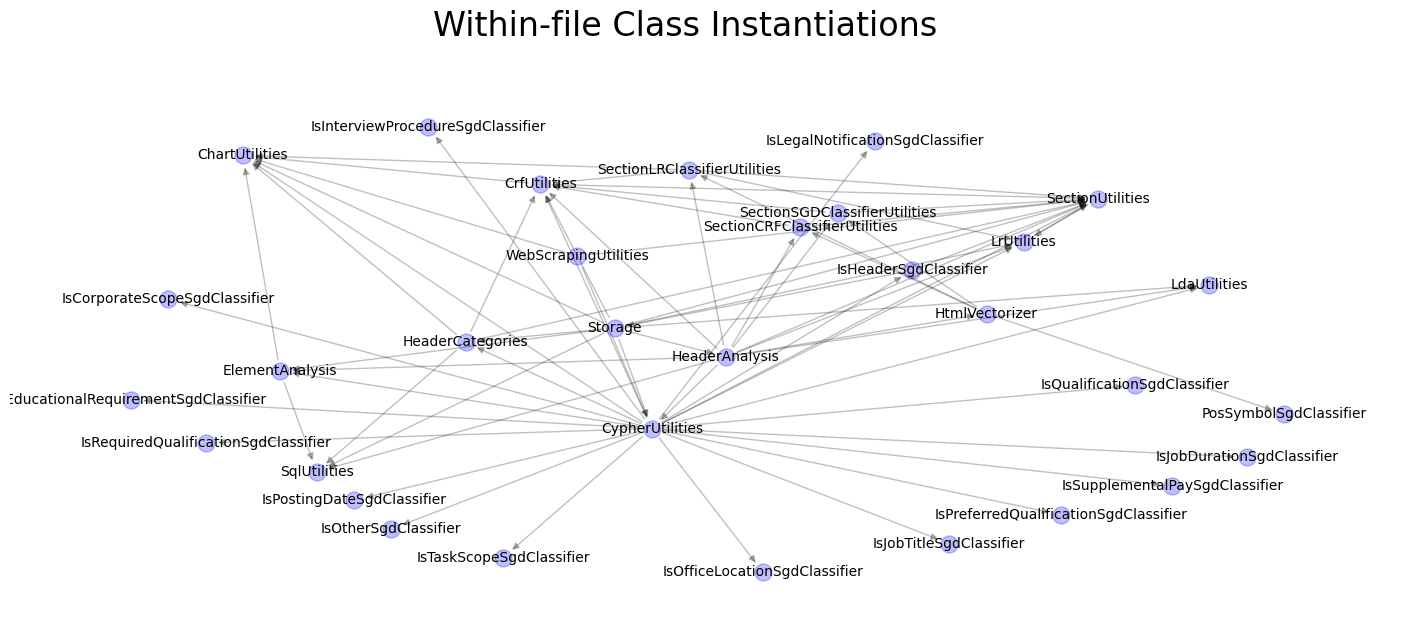

In [43]:

show_subgraph(dg, suptitle='Within-file Class Instantiations', verbose=False)

In [25]:

import pyperclip

class_name = 'sql_utils.py,SqlUtilities'
pyperclip.copy(r'\b([a-z_]+)\s*=\s*(' + class_name.replace('.py,', r'\.)?') + r'\b')

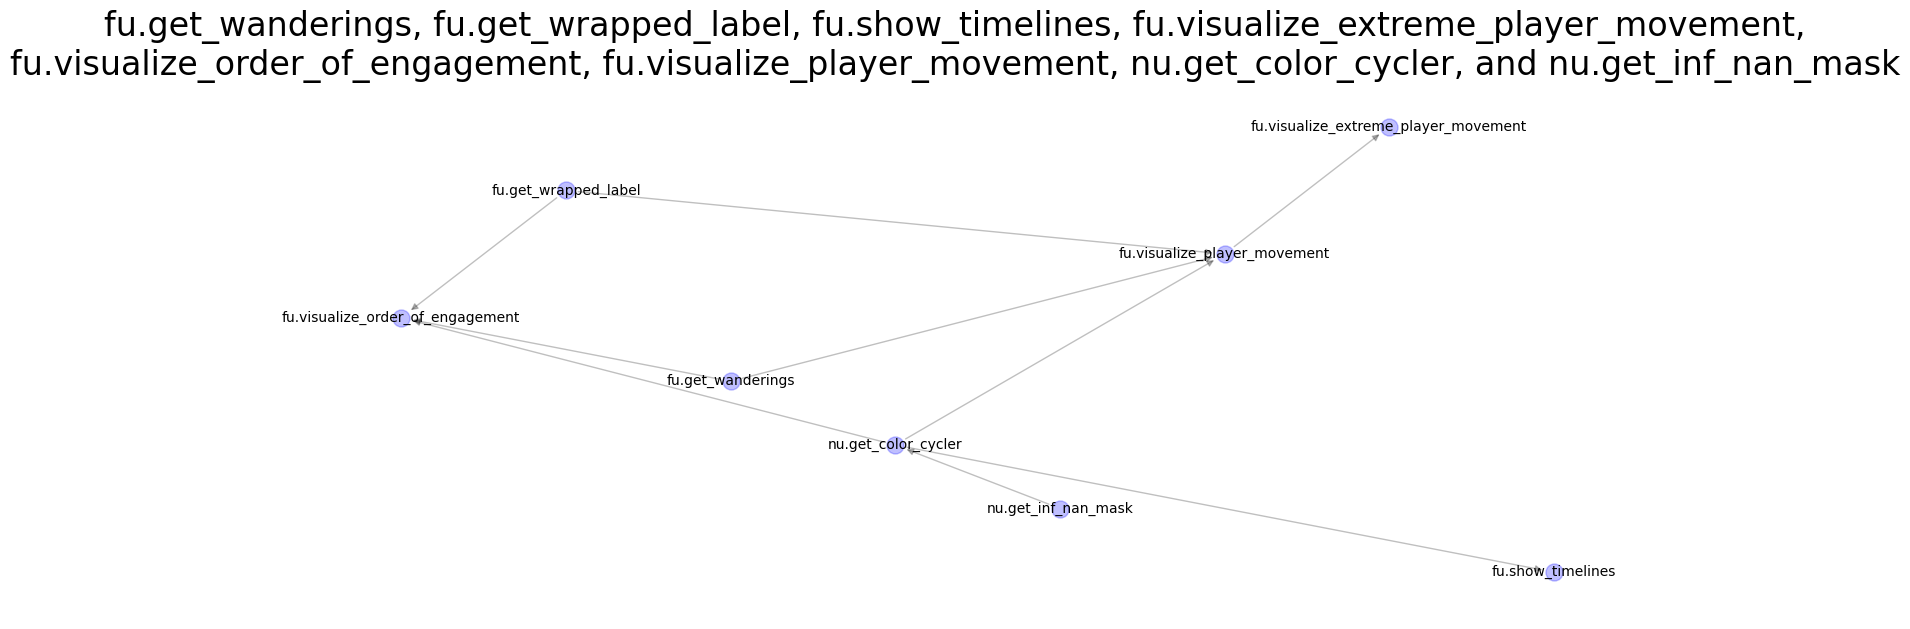

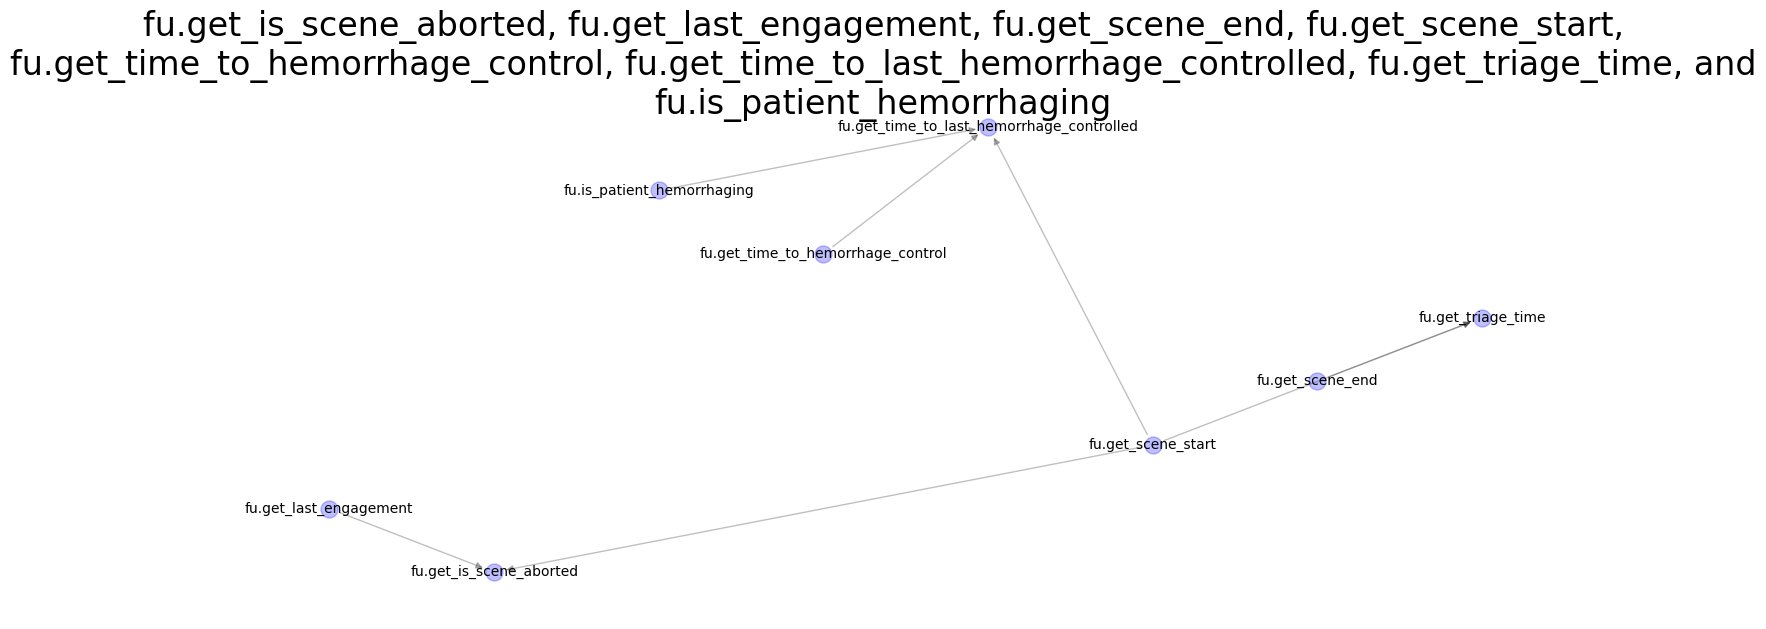

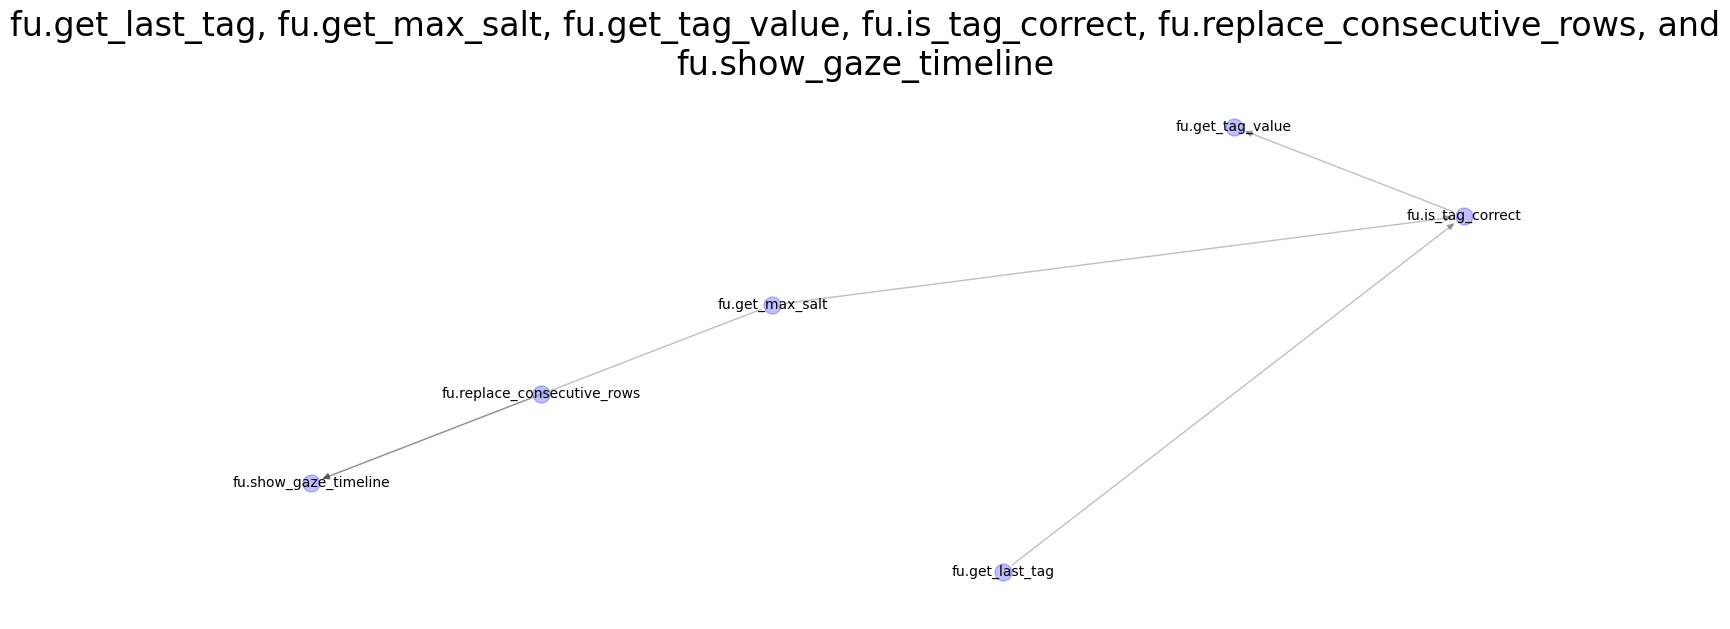

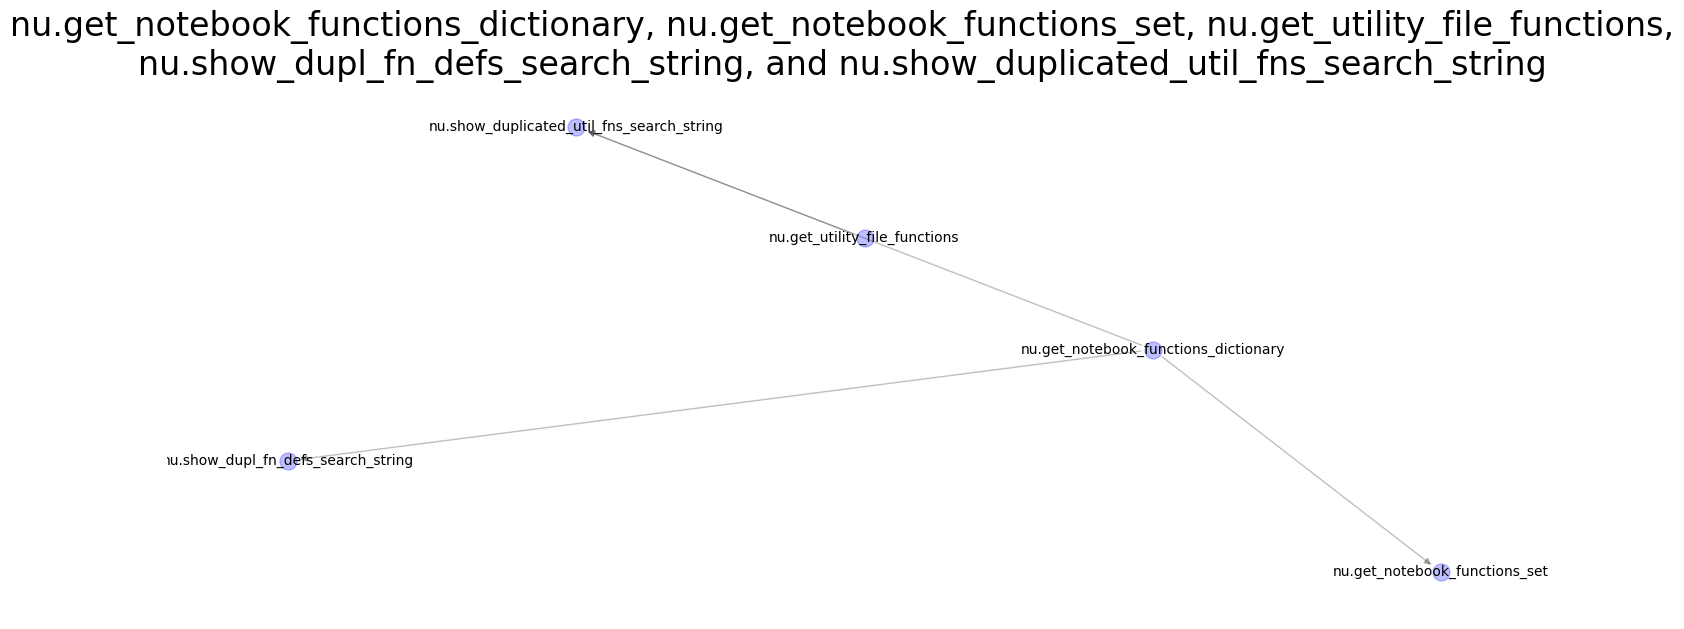

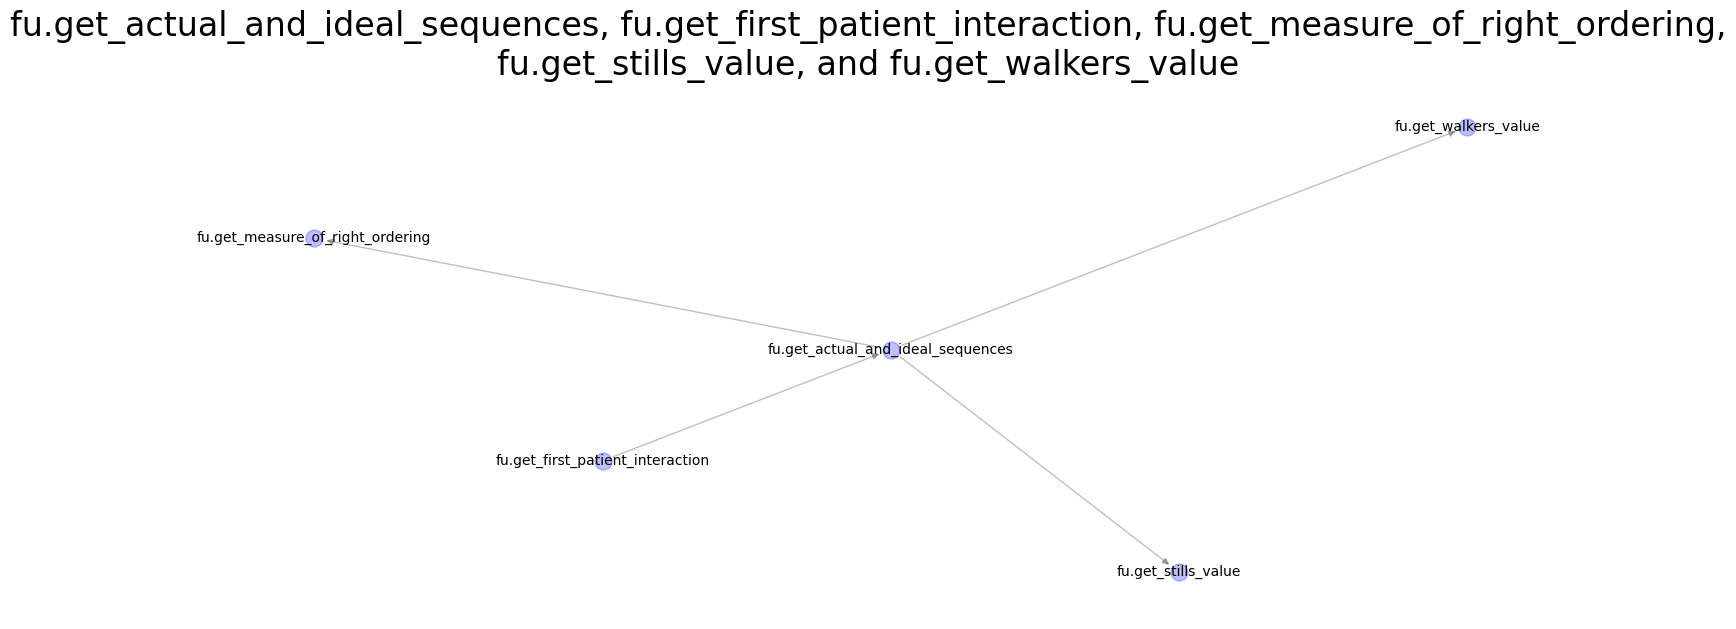

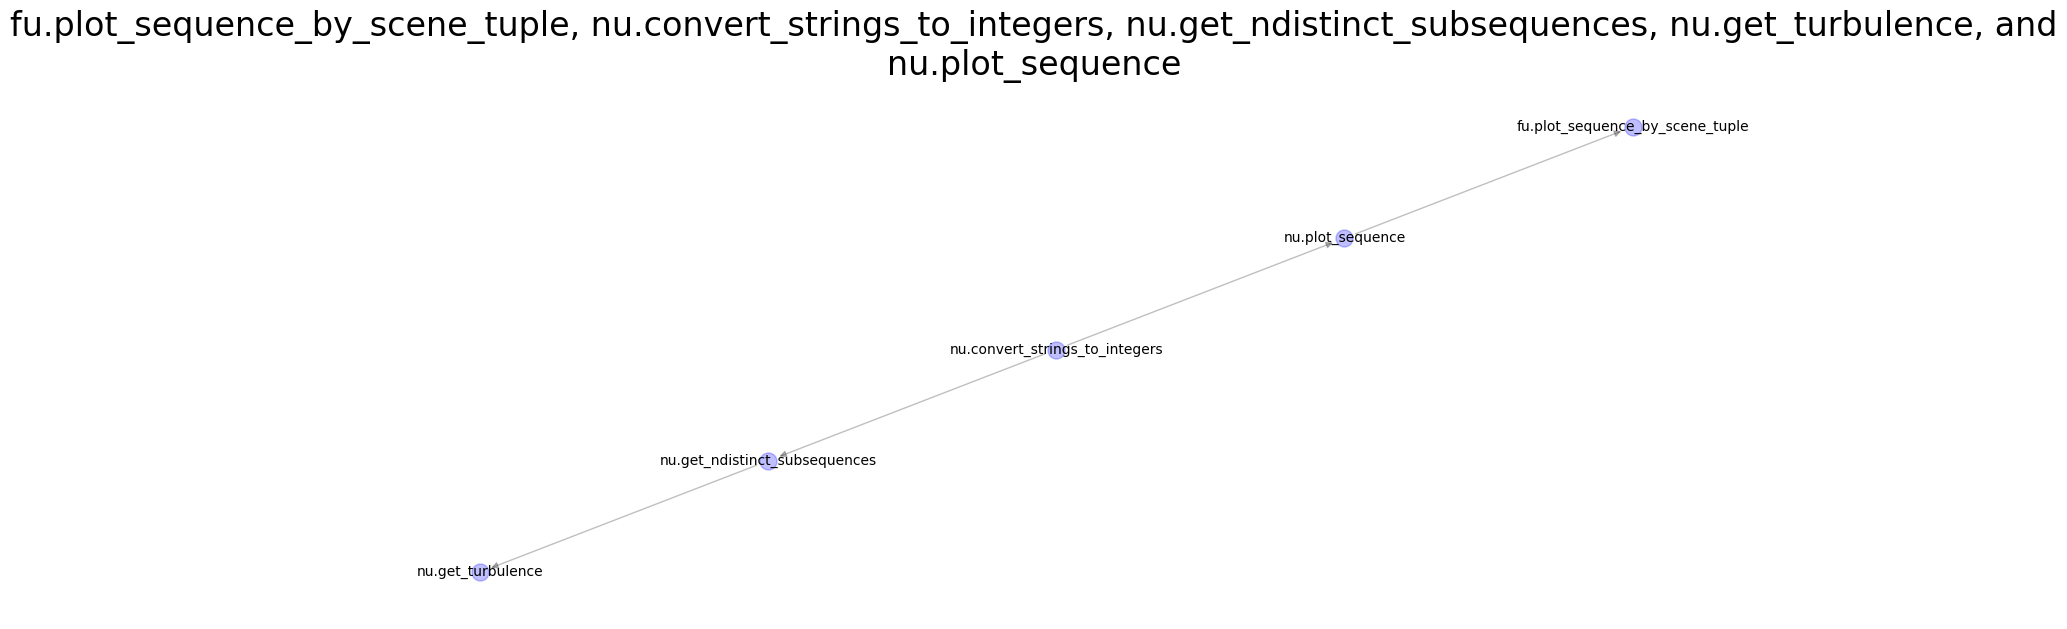

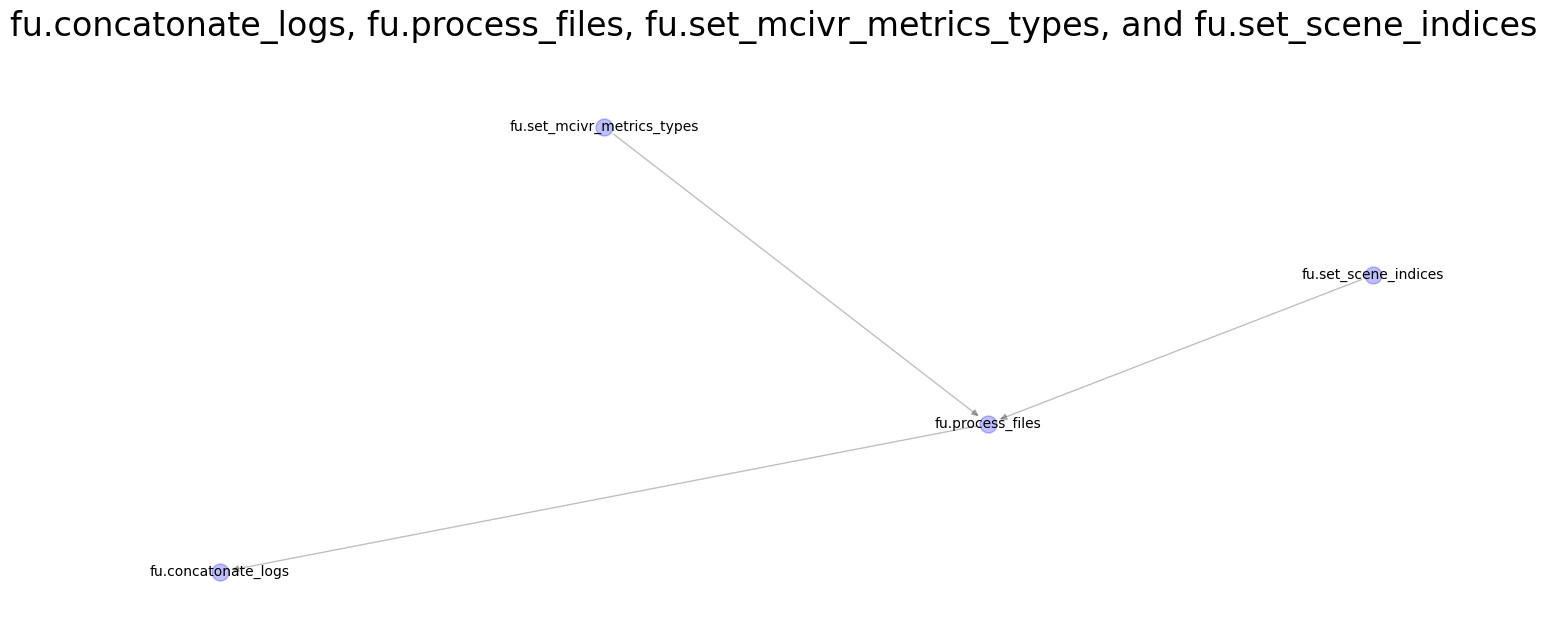

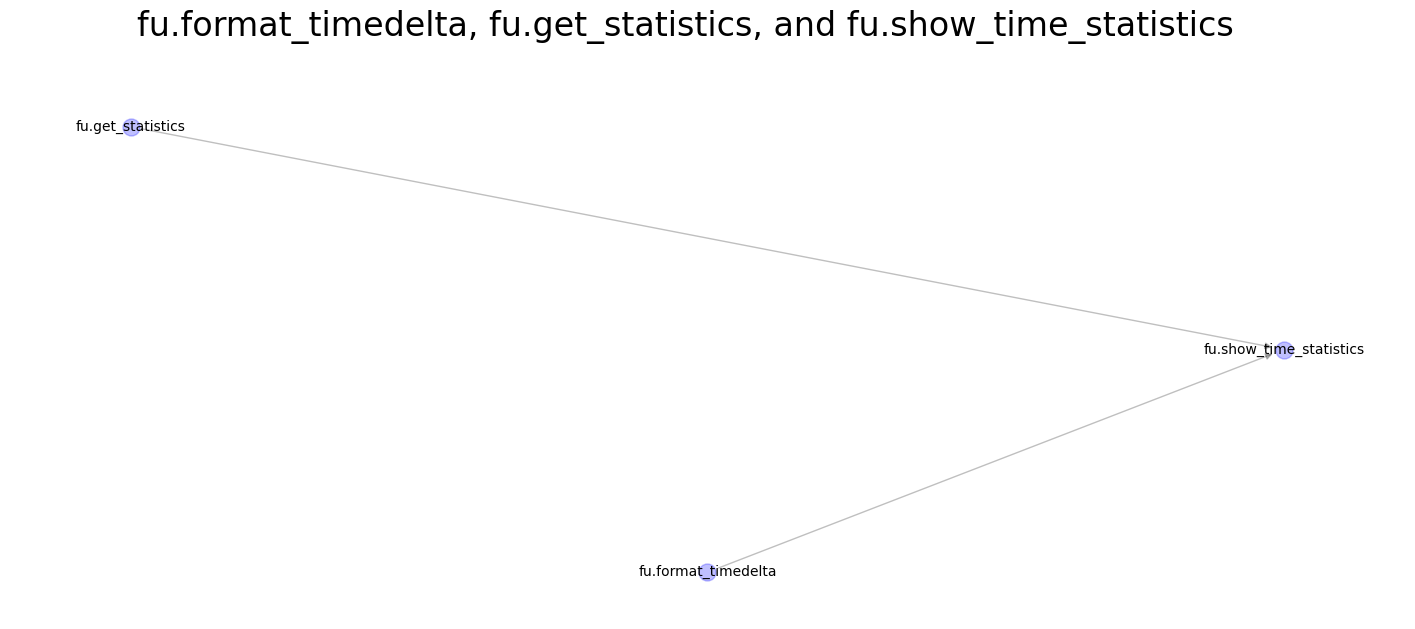

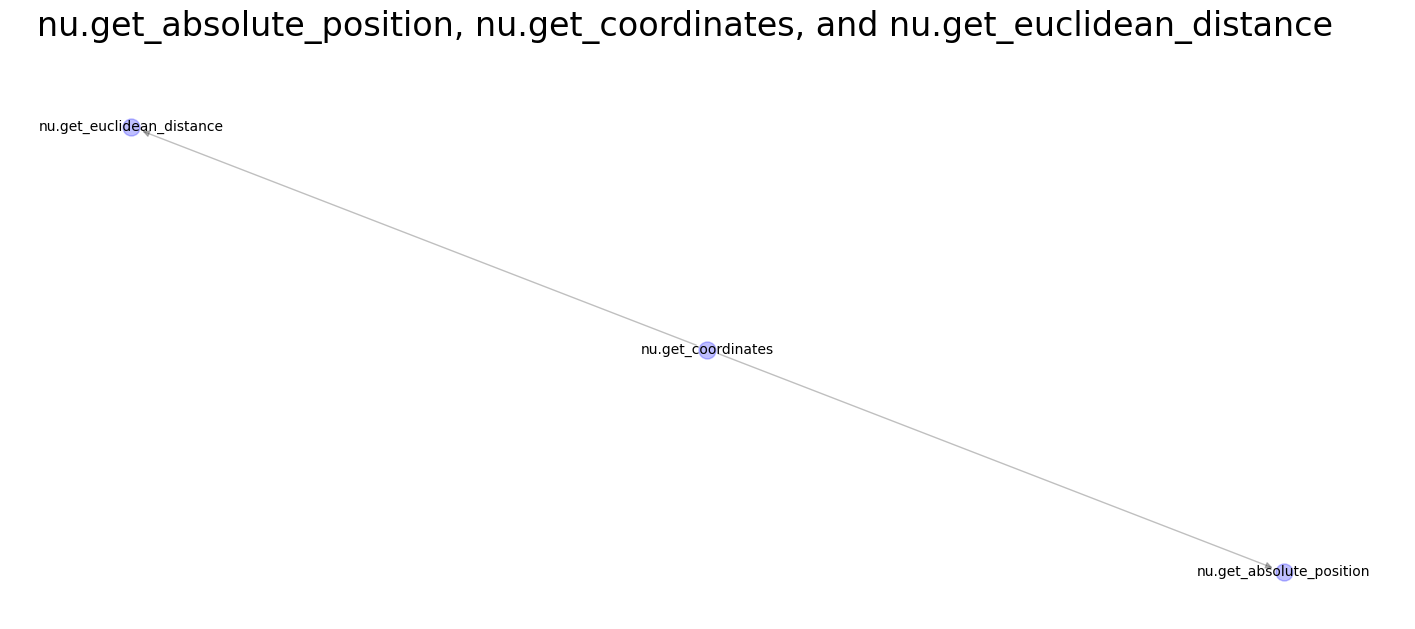

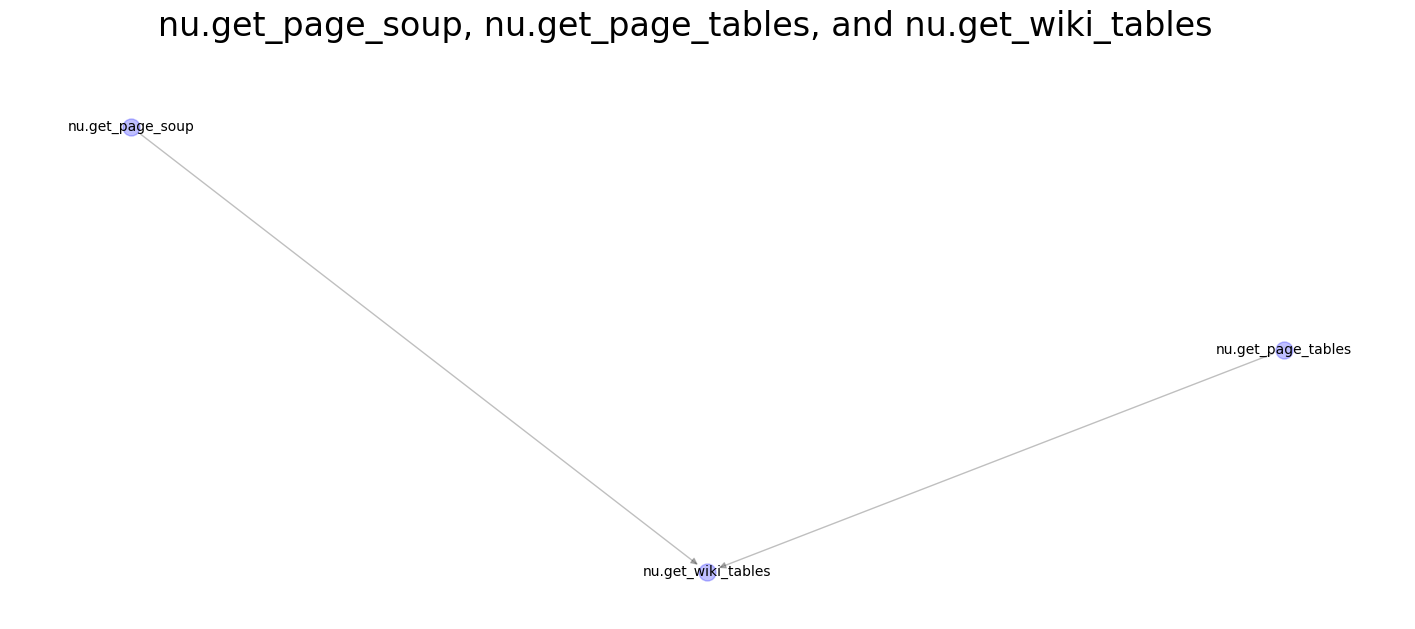

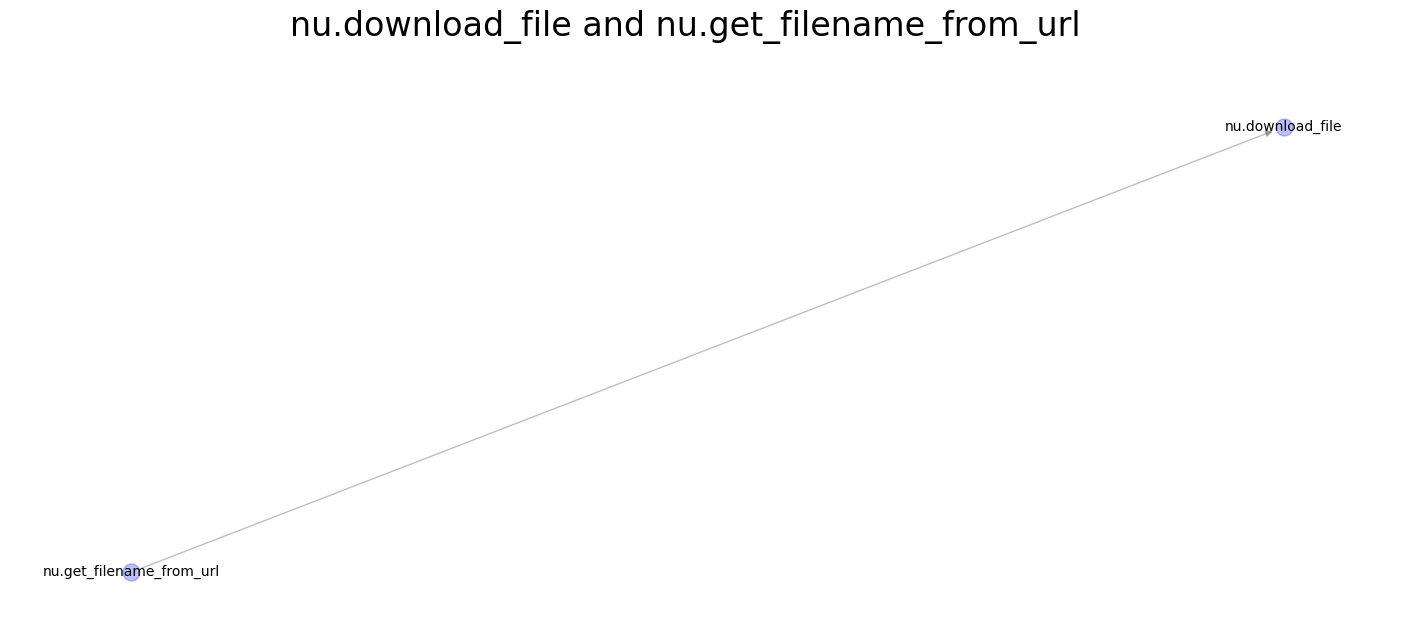

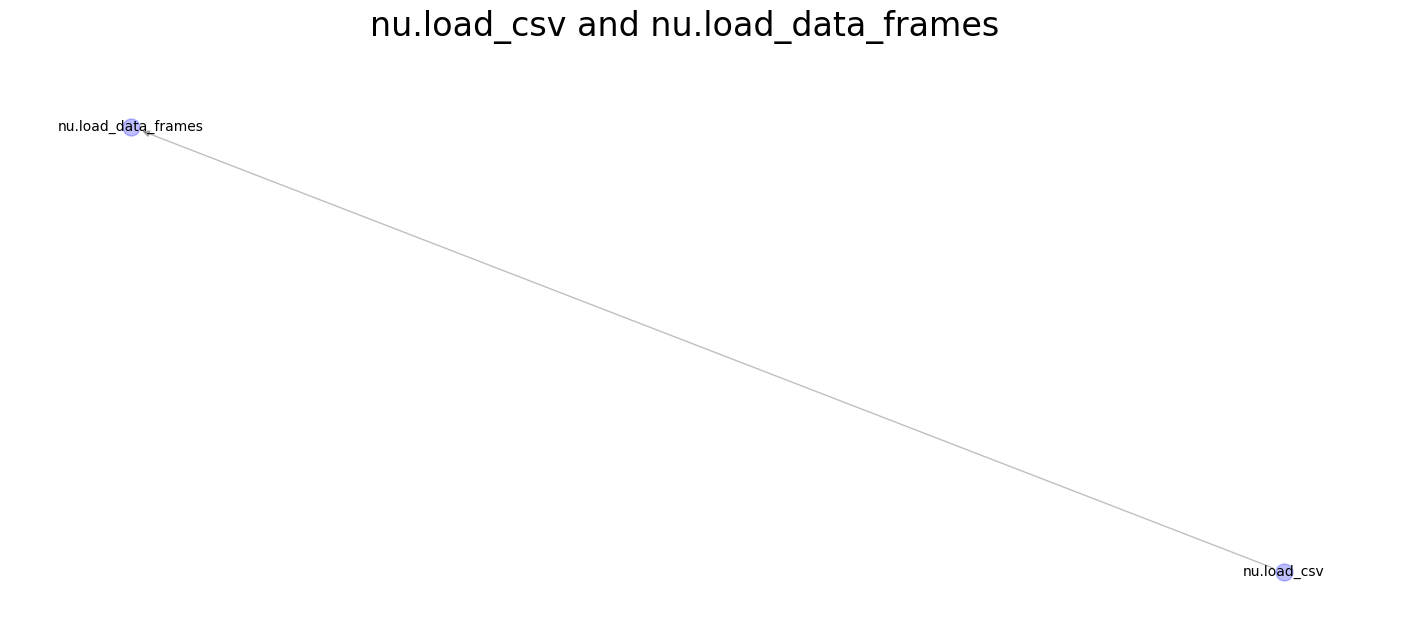

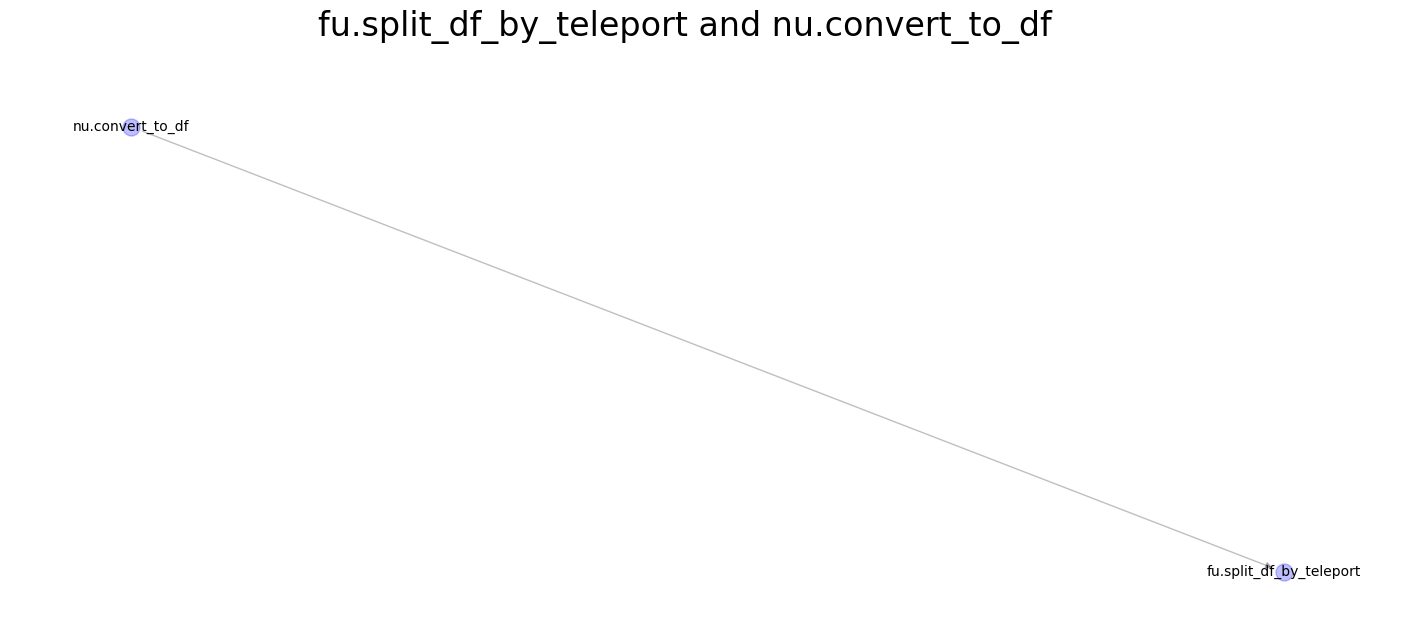

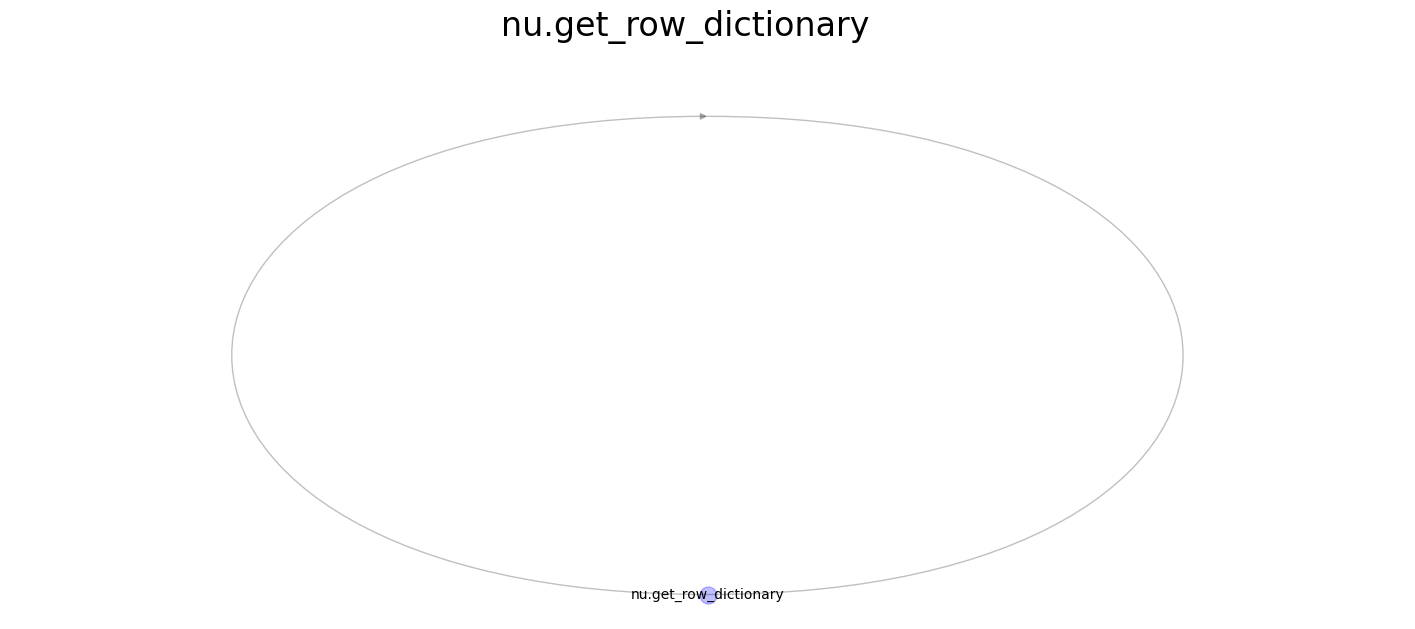

In [21]:

# Wrap the label to a specified width
import textwrap

for nodes_list in nodes_list_list:
    sub_graph = nx.subgraph(dg, nodes_list)
    suptitle = '\n'.join(textwrap.wrap(nu.conjunctify_nouns(nodes_list), width=120))
    show_subgraph(sub_graph, suptitle=suptitle)

In [67]:

[f'mpatches.ArrowStyle.{fn}' for fn in dir(mpatches.ArrowStyle) if not fn.startswith('_')]

['mpatches.ArrowStyle.BarAB', 'mpatches.ArrowStyle.BracketA', 'mpatches.ArrowStyle.BracketAB', 'mpatches.ArrowStyle.BracketB', 'mpatches.ArrowStyle.BracketCurve', 'mpatches.ArrowStyle.Curve', 'mpatches.ArrowStyle.CurveA', 'mpatches.ArrowStyle.CurveAB', 'mpatches.ArrowStyle.CurveB', 'mpatches.ArrowStyle.CurveBracket', 'mpatches.ArrowStyle.CurveFilledA', 'mpatches.ArrowStyle.CurveFilledAB', 'mpatches.ArrowStyle.CurveFilledB', 'mpatches.ArrowStyle.Fancy', 'mpatches.ArrowStyle.Simple', 'mpatches.ArrowStyle.Wedge', 'mpatches.ArrowStyle.get_styles', 'mpatches.ArrowStyle.pprint_styles', 'mpatches.ArrowStyle.register']

In [66]:

print(mpatches.ArrowStyle.pprint_styles())


    =============  ==========  ===============================================================================================================================
    Class          Name        Attrs                                                                                                                          
    =============  ==========  ===============================================================================================================================
    Curve          ``-``       None                                                                                                                           
    CurveA         ``<-``      head_length=0.4, head_width=0.2, widthA=1.0, widthB=1.0, lengthA=0.2, lengthB=0.2, angleA=0, angleB=0, scaleA=None, scaleB=None
    CurveB         ``->``      head_length=0.4, head_width=0.2, widthA=1.0, widthB=1.0, lengthA=0.2, lengthB=0.2, angleA=0, angleB=0, scaleA=None, scaleB=None
    CurveAB        ``<->``     head_length=0.


## List out various function calls

In [22]:

# Create a regular expression of all the non-staticmethod-decorated utils functions
instance_defs_regex = re.compile(r'^    def ([a-z]+[a-z_]+)\(\s*self,\s+(?:[^\)]+)\):', re.MULTILINE)
functions_list = []
for file_name in ['frvrs_utils.py', 'notebook_utils.py']:
    with open(f'../py/{file_name}', 'r', encoding=nu.encoding_type) as f: text = f.read()
    for match_obj in instance_defs_regex.finditer(text):
        functions_list.append(''.join([s[0] for s in file_name.split('.')[0].split('_')]) + '\\.' + match_obj.group(1))

instance_functions_regex = re.compile('\\b(' + '|'.join(functions_list) + ')\\b')

In [9]:

# Tabulate util function usage frequency
usage_frequency_dict = {}
all_calls_frequency_dict = {}
for sub_directory, directories_list, files_list in os.walk(nu.github_folder):
    if '.ipynb_checkpoints' not in sub_directory:
        for file_name in files_list:
            if file_name.endswith('.ipynb') and not ('Attic' in file_name):
                file_path = osp.join(sub_directory, file_name)
                with open(file_path, 'r', encoding=nu.encoding_type) as f:
                    lines_list = f.readlines()
                    for line in lines_list:
                        match_obj = instance_functions_regex.search(line)
                        if match_obj:
                            fn = match_obj.group(1)
                            usage_frequency_dict[fn] = usage_frequency_dict.get(fn, 0) + 1
                        match_obj = all_calls_regex.search(line)
                        if match_obj:
                            fn = match_obj.group()
                            all_calls_frequency_dict[fn] = all_calls_frequency_dict.get(fn, 0) + 1

In [10]:

usage_frequency_df = pd.Series(usage_frequency_dict).to_frame().reset_index().rename(columns={0: 'usage_frequency', 'index': 'function_call'})
usage_frequency_df.sort_values('usage_frequency', ascending=False).head(20)

,function_call,usage_frequency
11,fu.visualize_extreme_player_movement,36
4,fu.get_is_scene_aborted,25
5,nu.save_data_frames,20
13,nu.plot_sequence,17
25,fu.visualize_player_movement,15
12,fu.get_first_patient_interaction,14
26,fu.show_time_statistics,12
27,fu.plot_sequence_by_scene_tuple,10
17,nu.load_data_frames,9
21,nu.check_for_typos,8


In [11]:

all_calls_frequency_df = pd.Series(all_calls_frequency_dict).to_frame().reset_index().rename(columns={0: 'all_calls_frequency', 'index': 'function_call'})
all_calls_frequency_df.sort_values('all_calls_frequency', ascending=False).head(20)

,function_call,all_calls_frequency
14,fu.scene_groupby_columns,106
0,nu.pickle_exists,101
1,nu.load_object,101
3,nu.store_objects,85
2,fu.patient_groupby_columns,57
5,fu.get_session_groupby,39
44,fu.visualize_extreme_player_movement,36
20,nu.conjunctify_nouns,32
23,fu.get_logger_version,30
56,nu.get_sequences_by_count,27


In [ ]:

mask_series = (usage_frequency_df.usage_frequency == 1)
usage_frequency_df[mask_series]